In [16]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [59]:
%%time
train = pd.read_csv("./datasets/cov_filtered_3.5_training.csv", index_col=None)

CPU times: user 1.61 s, sys: 266 ms, total: 1.88 s
Wall time: 1.87 s


In [60]:
%%time
validation = pd.read_csv("./datasets/cov_filtered_3.5_validation.csv", index_col=None)

CPU times: user 594 ms, sys: 46.9 ms, total: 641 ms
Wall time: 658 ms


In [61]:
%%time
test = pd.read_csv("./datasets/cov_filtered_3.5_test.csv", index_col=None)

CPU times: user 578 ms, sys: 109 ms, total: 688 ms
Wall time: 628 ms


In [62]:
labels = pd.read_csv("labels.csv")
labels.columns = ["Label", "Cluster"]
labels_dict = {}
for i in range(75):
    labels_dict[labels.iloc[i,1]] = i
train["Classification"].replace(labels_dict, inplace=True)
validation["Classification"].replace(labels_dict, inplace=True)
test["Classification"].replace(labels_dict, inplace=True)

In [63]:
size = train.shape[1] - 1
x = train.iloc[:, 1:size]
y = train.iloc[:, [size]]
x_val = validation.iloc[:,1:size]
y_val = validation.iloc[:,[size]]
x_test = test.iloc[:,1:size]
y_test = test.iloc[:,[size]]

In [47]:
clf = LogisticRegression(random_state=123456, penalty='l2', solver="newton-cg", max_iter=100, multi_class="multinomial", n_jobs=-1)

In [48]:
%%time
clf.fit(x, y.values.ravel())

CPU times: user 219 ms, sys: 141 ms, total: 359 ms
Wall time: 3min 42s


LogisticRegression(multi_class='multinomial', n_jobs=-1, random_state=123456,
                   solver='newton-cg')

## Run only one box of the three below

In [39]:
# Run this to predict on validation set
y_pred = clf.predict(x_val)
cm = pd.DataFrame(metrics.confusion_matrix(y_val, y_pred))

In [50]:
# Run this to predict on training set
y_pred = clf.predict(x)
cm = pd.DataFrame(metrics.confusion_matrix(y, y_pred))

In [64]:
# Run this to predict on testing set
y_pred = clf.predict(x_test)
cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))

## 

In [65]:
new_cm = pd.DataFrame(columns = ["TN", "FP", "FN", "TP"])
for i in range(75):
    true_negative = 0
    for j in range(75):
        if j == i:
            continue
        true_negative += sum(cm[j][0:i].append(cm[j][i+1:]))
    new_cm.loc[i] = [true_negative, sum(cm[i][0:i].append(cm[i][i+1:])), sum(cm.iloc[i][0:i].append(cm.iloc[i][i+1:])), cm[i][i]]

In [66]:
cm = new_cm

In [67]:
labels = pd.read_csv("labels.csv")
dataset_sizes = pd.read_csv("subset sizes.csv", header = None)

In [68]:
cm["TN"] = cm["TN"].astype(np.int64)
cm["FP"] = cm["FP"].astype(np.int64)
cm["FN"] = cm["FN"].astype(np.int64)
cm["TP"] = cm["TP"].astype(np.int64)
cm = cm.assign(precision = cm["TP"] / (cm["TP"] + cm["FP"]))
cm["precision"].astype(np.float64)
#cm["precision"].fillna(1, inplace=True)
cm = cm.assign(recall = cm["TP"] / (cm["TP"] + cm["FN"]))
cm["recall"].astype(np.float64)
cm = cm.assign(f1 = 2 * 1 / ((1 / cm["precision"]) + (1 / cm["recall"])))
cm = cm.assign(fbeta = (1 + 0.5 ** 2) * (cm["precision"] * cm["recall"]) / ((0.5 ** 2 * cm["precision"]) + cm["recall"]))
cm["fbeta"].fillna(0, inplace=True)
cm["cluster"] = labels["0"]
cm = cm.merge(dataset_sizes, how = 'inner', left_on='cluster', right_on=0)
cm.drop(columns=0, inplace = True)
cm.rename(columns={1:"size"}, inplace = True)
cm["log_size"] = np.log2(cm["size"])

Text(0, 0.5, 'F-beta Score')

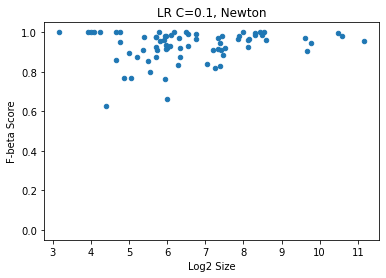

In [69]:
fig = cm.plot.scatter(x="log_size", y="fbeta", title="LR C=0.1, Newton", ylim=[-0.05,1.05]).get_figure()
plt.xlabel("Log2 Size")
plt.ylabel("F-beta Score")

In [45]:
pd.DataFrame(y_pred).to_csv("./default and optimal/lr_multi_optimal_Val_cov_3.5_pred.csv")

In [70]:
cm.to_csv("./default and optimal/lr_multi_optimal_test_cov_3.5.csv")